# Generalisation and overfitting

In this notebook we will explore the issue of overfitting and how we can measure how well the models we train generalise their predictions to unseen data. This will build upon the introduction to generalisation given in the [fourth lecture](http://www.inf.ed.ac.uk/teaching/courses/mlp/2016/mlp04-learn.pdf).

## Exercise: overfitting and model complexity in a 1D regression problem

As an exercise we will consider a regression problem. In particular we will attempt to use a multiple layer network model to learn to predict output values from inputs, given a fixed set of (noisy) observations of the underlying functional relationship between inputs and outputs. The aim of the exercise will be to visualise how increasing the complexity of the model we fit to the training data effects the ability of the model to make predictions across the input space.

### Function

To keep things simple we will consider a single input-output function defined by a fourth degree polynomial (quartic)

$$ f(x) = 10 x^4 - 17 x^3 + 8 x^2 - x $$

with the observed values being the function values plus zero-mean Gaussian noise

$$ y = f(x) + 0.01 \epsilon \qquad \epsilon \sim \mathcal{N}\left(\cdot;\,0,\,1\right) $$

The inputs will be drawn from the uniform distribution on $[0, 1]$.

First import the necessary modules and seed the random number generator by running the cell below.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
seed = 17102016 
rng = np.random.RandomState(seed)

Write code in the cell below to calculate a polynomial function of one dimensional inputs. 

If $\boldsymbol{c}$ is a length $P$ vector of coefficients corresponding to increasing powers in the polynomial (starting from the constant zero power term up to the $P-1^{\textrm{th}}$ power) the function should correspond to the following

\begin{equation}
  f_{\textrm{polynomial}}(x,\ \boldsymbol{c}) = \sum_{p=0}^{P-1} \left( c_p x^p \right)
\end{equation}

In [5]:
def polynomial_function(inputs, coefficients):
    """Calculates polynomial with given coefficients of an array of inputs.
    
    Args:
        inputs: One-dimensional array of input values of shape (num_inputs,)
        coefficients: One-dimensional array of polynomial coefficient terms
           with `coefficients[0]` corresponding to the coefficient for the
           zero order term in the polynomial (constant) and `coefficients[-1]`
           corresponding to the highest order term.
           
    Returns:
        One dimensional array of output values of shape (num_inputs,)
    
    """
    return (inputs[:, None]**np.arange(coefficients.shape[0])).dot(coefficients)

Run the cell below to test your implementation.

In [6]:
test_coefficients = np.array([-1., 3., 4.])
test_inputs = np.array([0., 0.5, 1., 2.])
test_outputs = np.array([-1., 1.5, 6., 21.])
assert polynomial_function(test_inputs, test_coefficients).shape == (4,), (
    'Function gives wrong shape output.'
)
assert np.allclose(polynomial_function(test_inputs, test_coefficients), test_outputs), (
    'Function gives incorrect output values.'
)

We now need to use the random number generator to sample input values and calculate the corresponding target outputs using your polynomial implementation with the relevant coefficients for our function. Do this by running the cell below.

In [7]:
coefficients = np.array([0, -1., 8., -17., 10.])
input_dim, output_dim = 1, 1
noise_std = 0.01
num_data = 80
inputs = rng.uniform(size=(num_data, input_dim))
epsilons = rng.normal(size=num_data)
targets = (polynomial_function(inputs[:, 0], coefficients) + 
           epsilons * noise_std)[:, None]

We will split the generated data points in to equal sized training and validation data sets and use these to create data provider objects which we can use to train models in our framework. As the dataset is small here we will use a batch size equal to the size of the data set. Run the cell below to split the data and set up the data provider objects.

In [8]:
from mlp.data_providers import DataProvider
num_train = num_data // 2
batch_size = num_train
inputs_train, targets_train = inputs[:num_train], targets[:num_train]
inputs_valid, targets_valid = inputs[num_train:], targets[num_train:]
train_data = DataProvider(inputs_train, targets_train, batch_size=batch_size, rng=rng)
valid_data = DataProvider(inputs_valid, targets_valid, batch_size=batch_size, rng=rng)

We can now visualise the data we will be modelling. Run the cell below to plot the target outputs against inputs for both the training and validation sets. Note the clear underlying smooth functional relationship evident in the noisy data.

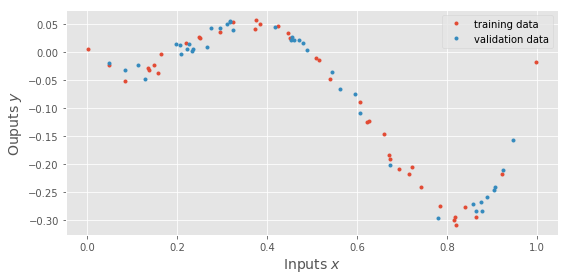

In [9]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.plot(inputs_train[:, 0], targets_train[:, 0], '.', label='training data')
ax.plot(inputs_valid[:, 0], targets_valid[:, 0], '.', label='validation data')
ax.set_xlabel('Inputs $x$', fontsize=14)
ax.set_ylabel('Ouputs $y$', fontsize=14)
ax.legend(loc='best')
fig.tight_layout()

### Model

We will fit models with a varying number of parameters to the training data. As multi-layer logistic sigmoid models do not tend to perform well in regressions tasks like this we will instead use a [radial basis function (RBF) network](https://en.wikipedia.org/wiki/Radial_basis_function_network).

This model predicts the output as the weighted sum of basis functions (here Gaussian like bumps) tiled across the input space. The cell below generates a random set of weights and bias for a RBF network and plots the modelled input-output function across inputs $[0, 1]$. Run the cell below for several different number of weight parameters (specified with `num_weights` variable) to get a feel for the sort of predictions the RBF network models produce.

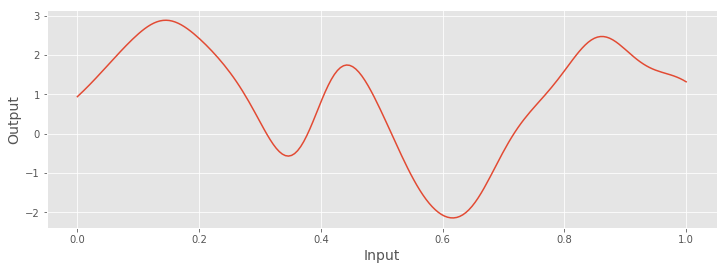

In [10]:
num_weights = 15
weights_scale = 1.
bias_scale = 1.

def basis_function(x, centre, scale):
    return np.exp(-(x - centre)**2 / scale**2)

weights = rng.normal(size=num_weights) * weights_scale
bias = rng.normal() * bias_scale

centres = np.linspace(0, 1, weights.shape[0])
scale = 1. / weights.shape[0]

xs = np.linspace(0, 1, 200)
ys = np.zeros(xs.shape[0])

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
for weight, centre in zip(weights, centres):
    ys += weight * basis_function(xs, centre, scale)
ax.plot(xs, ys)
ax.set_xlabel('Input', fontsize=14)
ax.set_ylabel('Output', fontsize=14)

You do not need to read in to the details of how to implement this model. All of the additional code you need to fit RBF networks is provided in the `RadialBasisFunctionLayer` in the `mlp.layers` module. The `RadialBasisFunctionLayer` class has the same interface as the layer classes we encountered in the previous lab, defining both `fprop` and `bprop` methods, and we can therefore include it as a layer in a `MultipleLayerModel` as with any other layer. 

Here we will use the `RadialBasisFunctionLayer` as the first layer in a two layer model. This first layer calculates the basis function terms which are then be weighted and summed together in an `AffineLayer`, the second and final layer. This illustrates the advantage of using a modular modelling framework - we can reuse the code we previously implemented to train a quite different model architecture just by defining a new layer class. 

Run the cell below to run some necessary setup code.

In [11]:
from mlp.models import MultipleLayerModel
from mlp.layers import AffineLayer, RadialBasisFunctionLayer
from mlp.errors import SumOfSquaredDiffsError
from mlp.initialisers import ConstantInit, UniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.optimisers import Optimiser

# Regression problem therefore use sum of squared differences error
error = SumOfSquaredDiffsError()
# Use basic gradient descent learning rule with fixed learning rate
learning_rule = GradientDescentLearningRule(0.1)
# Initialise weights from uniform distribution and zero bias
weights_init = UniformInit(-0.1, 0.1)
biases_init = ConstantInit(0.)
# Train all models for 2000 epochs
num_epoch = 2000

The cell below defines RBF network models with varying number of weight parameters (equal to the number of basis functions) and fits each to the training set, recording the final training and validation set errors for the fitted models. Run it now to fit the models and calculate the error values.

In [12]:
num_weight_list = [2, 5, 10, 25, 50, 100]
models = []
train_errors = []
valid_errors = []
for num_weight in num_weight_list:
    model = MultipleLayerModel([
        RadialBasisFunctionLayer(num_weight),
        AffineLayer(input_dim * num_weight, output_dim, 
                    weights_init, biases_init)
    ])
    optimiser = Optimiser(model, error, learning_rule, 
                          train_data, valid_data)
    print('-' * 80)
    print('Training model with {0} weights'.format(num_weight))
    print('-' * 80)
    _ = optimiser.train(num_epoch, -1)
    outputs_train = model.fprop(inputs_train)[-1]
    outputs_valid = model.fprop(inputs_valid)[-1]
    models.append(model)
    train_errors.append(error(outputs_train, targets_train))
    valid_errors.append(error(outputs_valid, targets_valid))
    print('  Final training set error: {0:.1e}'.format(train_errors[-1]))
    print('  Final validation set error: {0:.1e}'.format(valid_errors[-1]))

--------------------------------------------------------------------------------
Training model with 2 weights
--------------------------------------------------------------------------------
  Final training set error: 2.0e-03
  Final validation set error: 1.1e-03
--------------------------------------------------------------------------------
Training model with 5 weights
--------------------------------------------------------------------------------
  Final training set error: 4.5e-04
  Final validation set error: 3.0e-04
--------------------------------------------------------------------------------
Training model with 10 weights
--------------------------------------------------------------------------------
  Final training set error: 5.1e-05
  Final validation set error: 8.3e-05
--------------------------------------------------------------------------------
Training model with 25 weights
--------------------------------------------------------------------------------
  Final 

In the cell below write code to [plot bar charts](http://matplotlib.org/examples/api/barchart_demo.html) of the training and validation set errors for the different fitted models.

Some questions to think about from the plots:

  * Do the models with more free parameters fit the training data better or worse?
  * What does the validation set error value tell us about the models?
  * Of the models fitted here which would you say seems like it is most likely to generalise well to unseen data? 
  * Do any of the models seem to be overfitting?

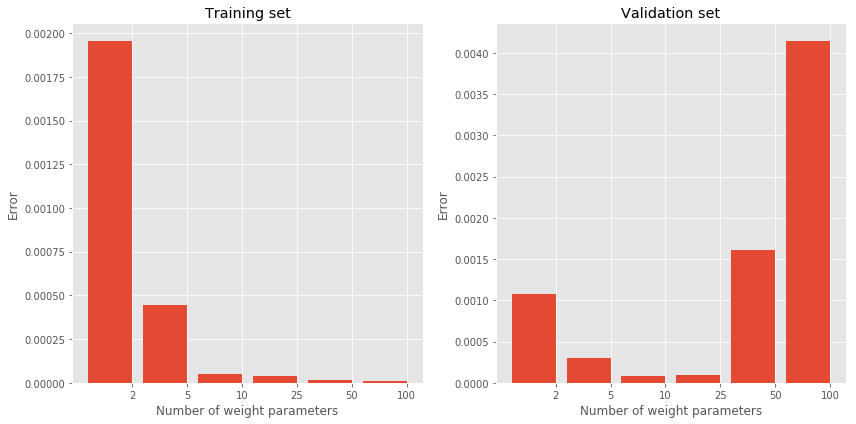

In [13]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.bar(0.1 + np.arange(len(num_weight_list)), train_errors)
ax1.set_xticks(0.5 + np.arange(len(num_weight_list)))
ax1.set_xticklabels(num_weight_list)
ax1.set_xlabel('Number of weight parameters')
ax1.set_ylabel('Error')
ax1.set_title('Training set')
ax2 = fig.add_subplot(1, 2, 2)
ax2.bar(0.1 + np.arange(len(num_weight_list)), valid_errors)
ax2.set_xticks(0.5 + np.arange(len(num_weight_list)))
ax2.set_xticklabels(num_weight_list)
ax2.set_xlabel('Number of weight parameters')
ax2.set_ylabel('Error')
ax2.set_title('Validation set')
fig.tight_layout()

Now let's visualise what the fitted model's predictions look like across the whole input space compared to the 'true' function we were trying to fit. 

In the cell below, for each of the fitted models stored in the `models` list above:
  * Compute output predictions for the model across a linearly spaced series of 500 input points between 0 and 1 in the input space.
  * Plot the computed predicted outputs and true function values at the corresponding inputs as line plots on the same axis (use a new axis for each model).
  * On the same axis plot the training data sets input-target pairs as points.

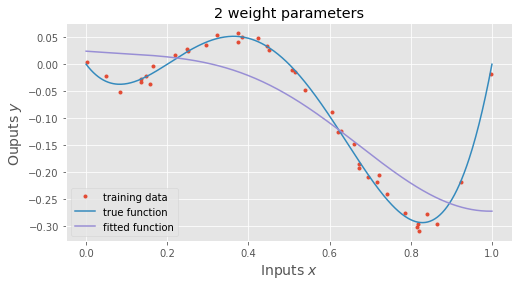

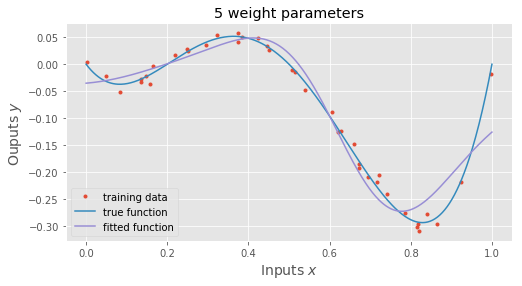

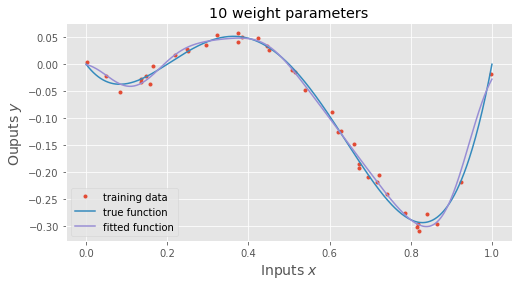

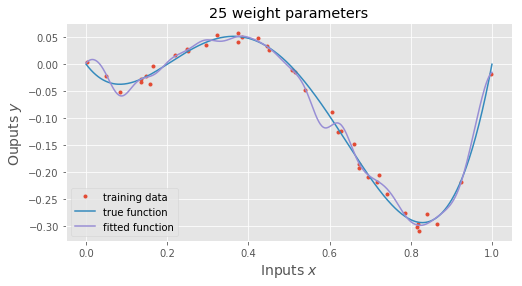

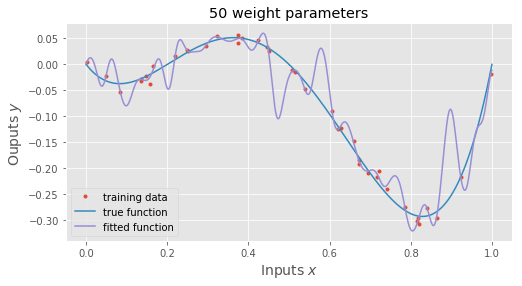

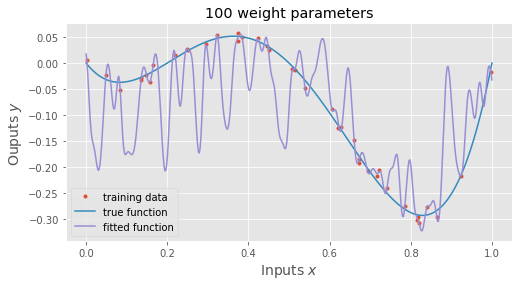

In [14]:
inputs_grid = np.linspace(0., 1., 500)
true_func_grid = polynomial_function(inputs_grid, coefficients)
for num_weight, model in zip(num_weight_list, models):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    outputs_grid = model.fprop(inputs_grid)[-1]
    ax.plot(inputs_train, targets_train, '.', label='training data')
    ax.plot(inputs_grid, true_func_grid, label='true function')
    ax.plot(inputs_grid, outputs_grid, label='fitted function')
    ax.set_xlabel('Inputs $x$', fontsize=14)
    ax.set_ylabel('Ouputs $y$', fontsize=14)
    ax.set_title('{0} weight parameters'.format(num_weight))
    ax.legend()

You should be able to relate your answers to the questions above to what you see in these plots - ask a demonstrator if you are unsure what is going on. In particular for the models which appeared to be overfitting and generalising poorly you should now have an idea how this looks in terms of the model's predictions and how these relate to the training data points and true function values.